In [1]:
import os
import math

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import HeatDiffusion, HeatDiffusion_Revised
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,gen_agents,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_samples

import matplotlib.pyplot as plt
import itertools
from typing import Optional

from matplotlib import cm


# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

model_path = os.path.join(args['log_path'], args['model_path'])

u0 = args['u0']
min_heat_step = args['min_heat_step']
max_heat_step = args['max_heat_step']
noise_steps = args['noise_steps']
sample_num = args['sample_num']
time_type = args['time_type']

train_lr = args['train_lr']
batch_size = noise_steps #args['batch_size']
seed = args['seed']

class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        if x_t is not None:
            score = bilinear_interpolate_samples(score_map, x_t)    # output: (B,2)
            return score, score_map.permute(0,2,3,1)
        else:
            return score_map.permute(0, 2, 3, 1)
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = HeatDiffusion_Revised(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

/home/mlcs_edf/mambaforge/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dt:tensor([   50,   128,   288,   578,  1058,  1922,  3200,  5408,  8978, 14450],
       device='cuda:0')
heat kernel std:tensor([ 5.,  8., 12., 17., 23., 31., 32., 32., 32., 32.], device='cuda:0')


In [2]:
# model.load_state_dict(torch.load(f'./runs/heat/Sep11_20-23-45_mlcs-graphics/model_params.pt'))
model.load_state_dict(torch.load(f'./runs/heat/Sep12_13-37-21_mlcs-graphics/model_params.pt'))

<All keys matched successfully>

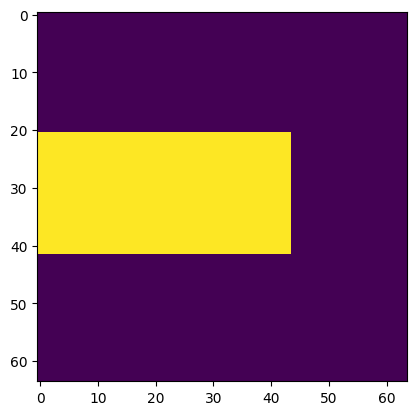

In [3]:
# Evaluation pre-setting

background = draw_obstacles_pil(bg, obstacle_pos)
obstacle_masks = convert_to_obstacle_masks(noise_steps, background[0].size, img_size, obstacle_pos)
# obstacle_masks = randgen_obstacle_masks(1, img_size, seed=seed)
# background = draw_obstacles_pixel(bg, obstacle_masks)

obstacle_masks = obstacle_masks[0].unsqueeze(0)

plt.imshow(obstacle_masks[0].cpu().numpy())
plt.show()


In [ ]:
# Evaluation - Single goal


lan_t = 100  # 4
epsilon = .01

goals = torch.tensor([[[0.7, -0.7]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)

heat_t = torch.tensor([i for i in range(1, noise_steps+1)], device=device)
heat, _, _, _ = diffusion.forward_diffusion(heat_t, goals.repeat(diffusion.noise_steps, 1, 1), 1, obstacle_masks.repeat(diffusion.noise_steps, 1, 1))
colormap = cm.get_cmap('hot')
def normalize_heat(array):
    min_val = array.min()
    max_val = array.max()
    return (array - min_val) / (max_val - min_val)
heat_bgs = [Image.fromarray((colormap(normalize_heat(heat[h].cpu().numpy()))[:, :, :3] * 255).astype(np.uint8)) for h in range(heat.size(0))]


c = 10
fig, axs = plt.subplots(1, c, figsize=(20,20))
fig.tight_layout()

T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 2

# img_sample = background.copy()

model.eval()
ims = []
ims_heat = []

with torch.no_grad():
    # x_T = torch.tensor([[[-0.8, 0.8]]], device=device, dtype=torch.float32)
    x_T = gen_agents(goal_bounds, (1000,1), img_size, obstacles=obstacle_masks, seed=seed)
    x = x_T
    
    for i in tqdm(reversed(range(1, T+1)), position=0):
        if (T-i) % step_size == 0:
            k = (T-i) // step_size
            backg = background.copy()
            heat_bg = [heat_bgs[i-1]]

            img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), dot_size)
            heat_sample = overlay_goal_agent(heat_bg, wastes, goals.cpu(), x.cpu(), dot_size)
            for s in range(len(img_sample)):
                if len(wastes) == 1:
                    axs[k].imshow(img_sample[s])
                    axs[k].set_title(f't = {T-i+1}')
                    axs[k].axis('off')
                    # axs[1,k].imshow(heat_sample[s])
                    # axs[1,k].set_title(f't = {T-i+1}')
                    # axs[1,k].axis('off')
                else:
                    axs[s,k].imshow(img_sample[s])
                    axs[0,k].set_title(f't = {T-i+1}')
                    axs[s,k].axis('off')

        t = (torch.ones(1) * i).long().to(device)

        alpha = epsilon / diffusion.std[i-1] * (img_size/2)
        
        for _ in range(lan_t):
            x_prev = x.clone()
            score, _ = model(obs_T, t, x)
            
            x = x_prev + (alpha * score)/2 + (torch.randn_like(x) * torch.sqrt(alpha) * 0.25)

            if not (x.abs() <=0.99).all():        
                x = x_prev
            bkg = background.copy()
            im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), dot_size)
            ims.append(im)
            ims_heat.append(overlay_goal_agent(heat_bg, wastes, goals.cpu(), x.cpu(), dot_size))
            

    backg = background.copy()
    heat_bg = [heat_bgs[i-1]]
    img_sample = overlay_goal_agent(backg, wastes, goals.cpu(),x.cpu(), dot_size)
    heat_sample = overlay_goal_agent(heat_bg, wastes, goals.cpu(), x.cpu(), dot_size)
    for s in range(len(img_sample)):
        if len(wastes) == 1:
            axs[-1].imshow(img_sample[s])
            axs[-1].set_title(f't = {T}')
            axs[-1].axis('off')    
            # axs[1,-1].imshow(heat_sample[s])
            # axs[1,-1].set_title(f't = {T}')
            # axs[1,-1].axis('off')
        else:
            axs[s,-1].imshow(img_sample[s])
            axs[0,-1].set_title(f't = {T}')
            axs[s,-1].axis('off')

    bkg = background.copy()
    im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), dot_size)
    ims.append(im)
    ims_heat.append(overlay_goal_agent(heat_bg, wastes, goals.cpu(), x.cpu(), dot_size))

In [12]:
baseline = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

baseline.load_state_dict(torch.load(f'./runs/baselines/Sep16_14-59-56/model_params.pt'))

<All keys matched successfully>

10it [00:24,  2.50s/it]


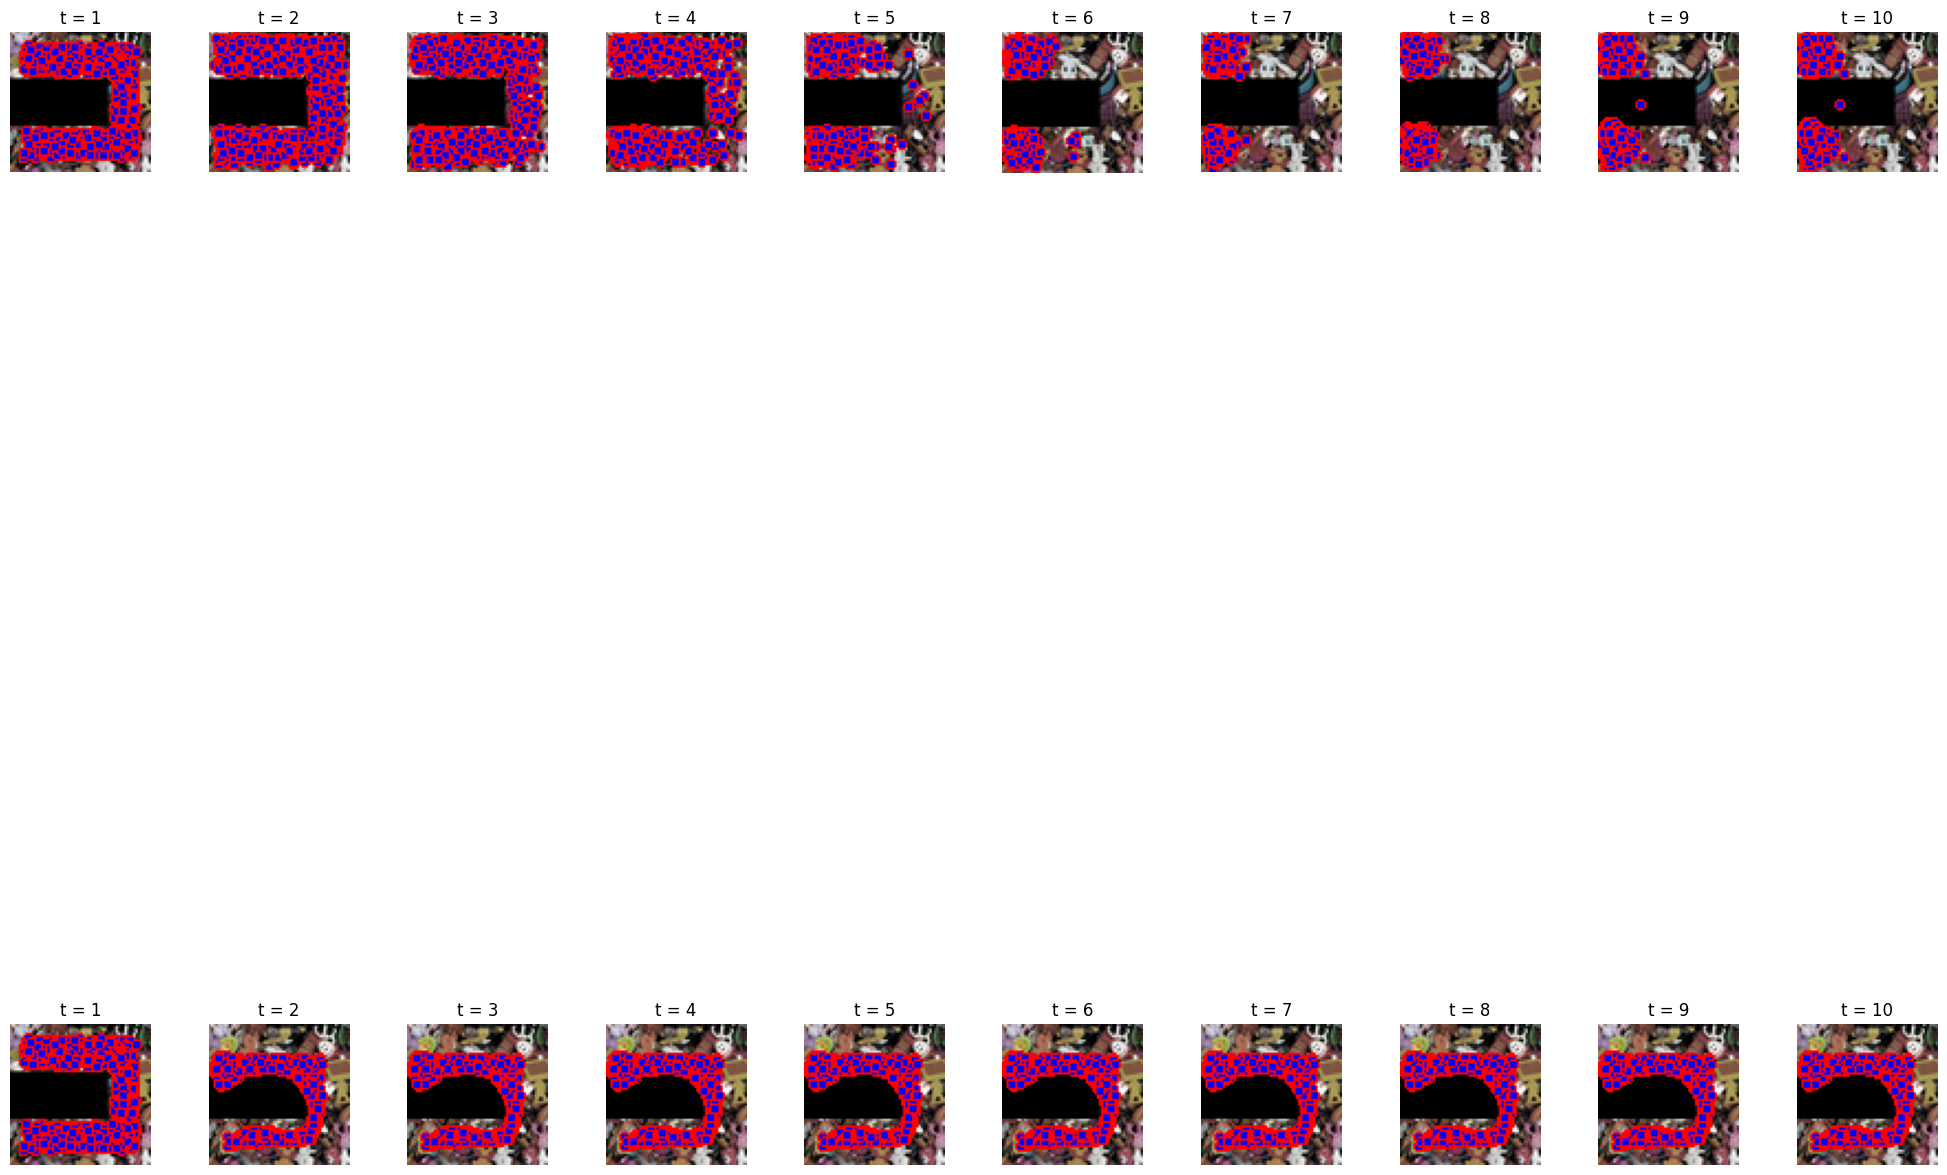

In [24]:
# Benchmark

lan_t = 200  # 4
epsilon = .01

goals = torch.tensor([[[0.7, -0.7], [-0.7, -0.7]]], device=device, dtype=torch.float32)
obs_T = overlay_goal(background, img_size, wastes, goals)

c = 10
fig, axs = plt.subplots(2, c, figsize=(20,20))
fig.tight_layout()

T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 2

model.eval()
baseline.eval()
ims = []

with torch.no_grad():
    # x_T = torch.tensor([[[-0.8, 0.8]]], device=device, dtype=torch.float32)
    x_T = gen_agents(goal_bounds, (1000,1), img_size, obstacles=obstacle_masks, seed=seed)
    x = x_T
    base_x = x_T
    
    for i in tqdm(reversed(range(1, T+1)), position=0):
        if (T-i) % step_size == 0:
            k = (T-i) // step_size
            backg = background.copy()

            img_sample = overlay_goal_agent(backg, wastes, goals.cpu(), x.cpu(), dot_size)
            base_sample = overlay_goal_agent(backg, wastes, goals.cpu(), base_x.cpu(), dot_size)
            for s in range(len(img_sample)):
                if len(wastes) == 1:
                    axs[0,k].imshow(img_sample[s])
                    axs[0,k].set_title(f't = {T-i+1}')
                    axs[0,k].axis('off')
                    axs[1,k].imshow(base_sample[s])
                    axs[1,k].set_title(f't = {T-i+1}')
                    axs[1,k].axis('off')

        t = (torch.ones(1) * i).long().to(device)
        base_t = torch.ones(1).long().to(device)

        alpha = epsilon / diffusion.std[i-1] * (img_size/2)
        
        for _ in range(lan_t):
            x_prev = x.clone()
            score, _ = model(obs_T, t, x)
            
            x = x_prev + (alpha * score)/2 + (torch.randn_like(x) * torch.sqrt(alpha) * 0.25)

            if not (x.abs() <=0.99).all():        
                x = x_prev
            bkg = background.copy()
            im = overlay_goal_agent(bkg, wastes, goals.cpu(), x.cpu(), dot_size)
            ims.append(im)
            ims_heat.append(overlay_goal_agent(heat_bg, wastes, goals.cpu(), x.cpu(), dot_size))


        for _ in range(40):            
            base_x_prev = base_x.clone()
            delta,_  = baseline(obs_T, base_t, base_x)

            base_x = base_x_prev + delta
            if not (base_x.abs() <=0.99).all():
                    base_x = base_x_prev
            

    backg = background.copy()
    img_sample = overlay_goal_agent(backg, wastes, goals.cpu(),x.cpu(), dot_size)
    base_sample = overlay_goal_agent(backg, wastes, goals.cpu(), base_x.cpu(), dot_size)
    for s in range(len(img_sample)):
        if len(wastes) == 1:
            axs[0,-1].imshow(img_sample[s])
            axs[0,-1].set_title(f't = {T}')
            axs[0,-1].axis('off')    
            axs[1,-1].imshow(base_sample[s])
            axs[1,-1].set_title(f't = {T}')
            axs[1,-1].axis('off')
